Formation OpenClassrooms DS-IML - **Marc Lefèvre**, <marc.lefevre@noos.fr>

# **Projet 7 : Classification de textes avec BERT**

### **Mission et contenu**

Ce 7ème projet consistait à effectuer une veille technologique et à mettre en pratique un procédé ou une technique récente en machine learning que nous aurions découvert à l'occasion de cette veille.<br><br>Nous avons choisi comme sujet les modèles <b>BERT</b> (Bidirectional Encoder Representation from Transformer), apparus fin 2018, qui proposent une représentation du langage sensée être meilleure et plus riche que ce qui existait avant.<br><br>Afin de le vérifier, nous avons prolongé notre <b>projet 5</b> ("classification de questions Stack-Overflow") en utilisant des modèles BERT. Ceux-ci allaient-ils nous permettre d'obtenir de meilleurs résultats ?

Dans ce premier notebook, nous avons travaillé à partir des données du projet 5. Mais comme vous pourrez le voir, nous avons pensé qu'il aurait pu être pertinent de disposer de plus de données.<br>Le second notebook, qui reprend quasiment le 1er du projet 5, retrace la construction d'un nouveau dataset plus conséquent.<br>Le troisième contient nos modélisations sur ce dataset plus grand. 

**Note :**<br>Ces notebooks sont assez redondants. Si le lecteur est intéressé par la façon dont on implémente <b>BERT</b>, tout est dans le détail de la première modélisation de ce présent document.

<b>Sources :</b><br>Voici quelques notebooks et ressources qui nous ont grandement aidés :<br>https://www.kaggle.com/anasofiauzsoy/tutorial-notebook<br>https://www.kaggle.com/c/contradictory-my-dear-watson<br>https://www.kaggle.com/katharinamenz/tutorial-notebook-edited-by-katharinamenz<br>https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

## **1ère partie : Modélisations avec données originales du P5**

## **1-) Opérations préliminaires**

**Liaison Google Drive**

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Installation du module **transformer** de **HugginFace**.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 5.3MB/s 
     |████████████████████████████████| 901kB 30.1MB/s 
     |████████████████████████████████| 3.3MB 52.5MB/s 


**Importations Python**

In [ ]:
import shutil
import os
import pickle
import numpy as np
import pandas as pd

from time import time

os.environ["WANDB_API_KEY"] = "0" ## to silence warning


from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizerFast, TFDistilBertModel, AutoTokenizer, TFAutoModel, TFRobertaModel#, DistilBertConfig
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score

Importation des données depuis **Google Drive**.

In [ ]:
cwd = os.getcwd()

path_data = cwd + "/drive/MyDrive/P7/Data/"

for file in os.listdir(path_data) :

    if file != "Models" :
        shutil.copy(os.path.join(path_data, file), cwd)

# Vérification de l'importation
os.listdir(cwd)

['.config',
 'big_y_test.pickle',
 'feat_clean_train.pickle',
 'df_targ.pickle',
 'big_feat_test.pickle',
 'feat_test.pickle',
 'y_test.pickle',
 'feat_train.pickle',
 'big_labels.pickle',
 'big_y_train.pickle',
 'big_feat_train.pickle',
 'drive',
 'labels.pickle',
 'feat_sw_test.pickle',
 'feat_sw_train.pickle',
 'y_train.pickle',
 'big_df_targ.pickle',
 'feat_clean_test.pickle',
 'sample_data']

**Configuration de l'environnement TPU**

Avec des modèles BERT, il est recommandé de si possible utiliser du hardware de type **TPU** (Tensor Processing Unit). L'utilisation de TPU n'est pas automatique, elle nécessite deux choses :<br>- D'abord d'être initialisée (cellule ci-dessous)<br>- Puis que chaque modèle les utilisant soit instancié plus tard dans le cadre de la "stratégie de calcul" définie lors de cette initialisation.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # detect and init the TPU: TPUClusterResolver() locates the TPUs on the network
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # "strategy" contains the necessary distributed training code that will work on the TPUs
except ValueError: # in case Accelerator is not set to TPU in the Notebook Settings
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.17.48.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.17.48.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## **2-) Modélisations tests : types de texte & cased/uncased**

Les modèles de types **BERT** ont la particularité, en NLP, de mieux fonctionner avec du texte pure. C'est à dire avec du texte tel qu'il a été écrit, avec tous ses mots, tous ses éléments syntaxiques, et tous ses signes.<br>Nous allons dans un premier temps le vérifier en utilisant un modèle sur des données non traitées, puis des données à qui ont a enlevé chiffres et certains signes, puis enfin des données à qui on a enlevé en plus ponctuation et "stopwords".

**Chargement des données**

In [ ]:
X_train = pickle.load(open("feat_train.pickle", "rb"))
X_test = pickle.load(open("feat_test.pickle", "rb"))

X_clean_train = pickle.load(open("feat_clean_train.pickle", "rb"))
X_clean_test = pickle.load(open("feat_clean_test.pickle", "rb"))

X_sw_train = pickle.load(open("feat_sw_train.pickle", "rb"))
X_sw_test = pickle.load(open("feat_sw_test.pickle", "rb"))

y_train = pickle.load(open("y_train.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))

y_train = y_train.toarray()
y_test = y_test.toarray()

On a bien trois types de données texte :

In [ ]:
X_train[5]

"angular2: insert a dynamic component as child of a container in the dom. Is there a way to insert dynamically a component as a child (not a sibling) of a DOM tag in Angular 2? There are plenty of examples around there to insert a dynamic component as a sibling of a given ViewContainerRef's tag, like (as of RC3): But this generates a DOM similar to: Expected result: Using the SomeComponent's ViewContainerRef has the same result, it is still inserting the generated component as a sibling, not a child. I would be okay with a solution where the template is empty and dynamic components are inserted in the template (within the component selector tag). The DOM structure is very important when using libraries like ng2-dragula to drag from a list of dynamic components and benefit from the model updates. The extra div is in the list of draggable elements, but outside the model, breaking the drag & drop logic. Some say it is not possible (c.f. this comment), but it sounds like a very surprising 

In [ ]:
X_clean_train[5]

'angular: insert a dynamic component as child of a container in the dom. is there a way to insert dynamically a component as a child not a sibling of a dom tag in angular ? there are plenty of examples around there to insert a dynamic component as a sibling of a given viewcontainerrefs tag, like as of rc: but this generates a dom similar to: expected result: using the somecomponents viewcontainerref has the same result, it is still inserting the generated component as a sibling, not a child. i would be okay with a solution where the template is empty and dynamic components are inserted in the template within the component selector tag. the dom structure is very important when using libraries like ngdragula to drag from a list of dynamic components and benefit from the model updates. the extra div is in the list of draggable elements, but outside the model, breaking the drag  drop logic. some say it is not possible c.f. this comment, but it sounds like a very surprising limitation.'

In [ ]:
X_sw_train[5]

'angular insert dynamic component child container dom way insert dynamically component child sibling dom tag angular plenty examples insert dynamic component sibling given viewcontainerrefs tag like rc generates dom similar expected result somecomponents viewcontainerref result inserting generated component sibling child okay solution template dynamic components inserted template component selector tag dom structure important libraries like ngdragula drag list dynamic components benefit model updates extra div list draggable elements outside model breaking drag drop logic possible c.f comment sounds like surprising limitation'

## **2-a) Déroulement détaillé d'une modélisation BERT : DistilBERT cased données brutes**

Nous allons maintenant détailler notre première modélisation, avec le modèle **DistilBERT** (une version allégée de BERT) sur les données texte brutes. On commence par la version **cased** du modèle (qui tient compte des majuscules) avant d'essayer ensuite la version **uncased**.

**Longueur maximum des questions**

Il nous faut d'abord définir une **longueur** des features qu'on envoie au modèle. Cette longueur est le nombre de tokens maximum d'une question. Si une question est composée de moins de tokens, il y aura un padding automatique. Si une question est composée de plus de token que ce nombre, elle sera coupée et ce qui "dépasse" sera ignoré.

**Elements statistiques sur le nombre de mots par question**

In [ ]:
print(f"Nombre de questions d'entrainement : {len(X_train)}")
print(f"Nombre de questions de test : {len(X_test)}")

Nombre de questions d'entrainement : 20000
Nombre de questions de test : 5555


Pour avoir une approximation des nombres de mots dans nos textes, on compte le nombre d'éléments séparés par des espaces.

In [ ]:
def stats(X_train, X_test):

    longueurs_train = []
    longueurs_test = []

    for quest in X_train :
        longueurs_train.append(len(quest.split(" ")))
    l_train_max = max(longueurs_train)

    for quest in X_test :
        longueurs_test.append(len(quest.split(" ")))
    l_test_max = max(longueurs_test)


    print(f"Nombre de mots max dans les données d'entrainement : {l_train_max}")
    print(f"Nombre de mots moyen dans les données d'entrainement : {np.mean(longueurs_train):.2f}")
    print(f"Déviation standart du nombre de mots dans les données d'entrainement : {np.std(longueurs_train):.2f}")

    print()
    print(f"Nombre de mots max dans les données de test : {l_test_max}")
    print(f"Nombre de mots moyen dans les données de test : {np.mean(longueurs_test):.2f}")
    print(f"Déviation standart du nombre de mots dans les données de test : {np.std(longueurs_test):.2f}")

In [ ]:
stats(X_train, X_test)

Nombre de mots max dans les données d'entrainement : 8210
Nombre de mots moyen dans les données d'entrainement : 95.11
Déviation standart du nombre de mots dans les données d'entrainement : 108.89

Nombre de mots max dans les données de test : 2627
Nombre de mots moyen dans les données de test : 94.31
Déviation standart du nombre de mots dans les données de test : 93.46


Etant donnés ces résultats, et étant donné que les tokenizers des modèles BERT décomposent les mots par "sub-words" (et non par mots entiers), on décide de prendre la longueur maximum standard qui est de **512** tokens.

In [ ]:
MAX_LENGTH = 512
BATCH_SIZE = 32

**Tokenination**

Chaque modèle BERT dispose de son tokenizer associé qu'on commence par charger.

In [ ]:
model_name = 'distilbert-base-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

Ce tokenizer va créer les **deux tenseurs** qui seront les **inputs** du modèle.<br>Les **input_ids**, qui sont principalement des clés permettant d'identifier chaque token dans le vocabulaire du modèle pré-entrainés.<br>Les **attention_mask** qui sont des masques indiquant au modèle le nombre de tokens à prendre en compte dans une feature.<br><br>On opère la tokenization grâce à la fonction suivante.

In [ ]:
def batch_encode(tokenizer, data, batch_size=BATCH_SIZE, max_length=MAX_LENGTH):
    """
    Fonction d'encodage/tokenisation des données
    """
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding= "max_length",
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

Mise en pratique...

In [ ]:
start = time()
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

data = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 17 secondes.


**Création du modèle**

Fonction de création du modèle ci-dessous.<br><br>La modélisation avec des modèles BERT ressort du **transfert learning**. Notre modèle est l'adjonction d'une couche dense de classification à un modèle BERT pré-entrainé. Dans un premier temps on entrainera la partie classification ("freeze" de la partie BERT ici...) avant une phase de "fine-tuning".<br><br>**Très important :**<br>Un modèle BERT fournit un output (de dimension 768) par token de l'input concerné. Celui qui nous intéresse est le premier de ces outputs, qui correspond à une représentation globale de nos questions encodées.<br><br>**Rappel :**<br>Nous sommes dans un cadre de **classification multi-label** à **25 classes**. Notre couche de sortie a donc **25 neurones** et une **activation sigmoïde**. La fonction de coût est la **binary_crossentropy** car une modélisation multi-label s'envisage comme une succession de classifications binaires.

In [ ]:
def build_distil_model_cased(max_length = MAX_LENGTH):

    distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-cased')

    # DistilBERT est non-entrainable dans un premier temps
    for layer in distilBERT.layers:
        layer.trainable = False
    
    # Définition des entrées
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # C'est sur le premier output du modèle que nous effectuons la classificaztion.
    last_hidden_state = distilBERT([input_ids_layer, input_attention_layer])[0]
    cls_token = last_hidden_state[:, 0, :]
    
    # Définition de notre partie classification
    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    # Définition du modèle
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compilation
    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')
    
    return model

**Instanciation du modèle**<br>Comme nous l'avons dit plus tôt, les modèles sont créés dans le cadre de la "stratégie" d'utilisation des **TPU**.

In [ ]:
with strategy.scope():
    model_dist_raw_cased = build_distil_model_cased()

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**Modélisation**

In [ ]:
def modelize(model, epochs, data, mod_name, batch = BATCH_SIZE):
    """
    Fonction de modélisation.
    """
    checkpoint = ModelCheckpoint(filepath = "drive/MyDrive/P7/Data/Models/" + mod_name + ".hdf5", 
                                 monitor = "val_accuracy",
                                 verbose = 0,
                                 save_weights_only = True,
                                 save_best_only = True)
    
    start = time()

    history = model.fit(data[0],
                        data[1],
                        epochs = epochs,
                        batch_size = batch,
                        validation_split = 0.2,
                        callbacks = [checkpoint])
    
    preds = model.predict(data[2])
    
    preds = preds.round()
    
    f1_sc = f1_score(data[3],
                     preds,
                     average = "weighted")
    
    fig = plt.figure(figsize = (10,4))

    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    plt.plot(range(1, epochs+1), train_acc, 'b', label='Train acc', color = "red")
    plt.plot(range(1, epochs+1), val_acc, 'b', label='Validation acc', color = "blue")
    plt.title('Train & validation accuracies - ' + mod_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    print()
    print(f"Temps d'entrainements pour {epochs} epochs : {time()-start:.0f} secondes.")
    print(f"Meilleure train_acc = {np.max(train_acc):.3f}, meilleure val_acc = {np.max(val_acc):.3f}")
    print()
    print(f"F1_score obtenu : {f1_sc:.2f}")

    plt.show()

Epoch 1/50


499/500 [============================>.] - ETA: 0s - loss: 0.1920 - accuracy: 0.2147WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 25s 31ms/step - loss: 0.1920 - accuracy: 0.2148 - val_loss: 0.1778 - val_accuracy: 0.2575
Epoch 2/50
500/500 [==============================] - 11s 21ms/step - loss: 0.1732 - accuracy: 0.2819 - val_loss: 0.1680 - val_accuracy: 0.3103
Epoch 3/50
500/500 [==============================] - 11s 21ms/step - loss: 0.1659 - accuracy: 0.3129 - val_loss: 0.1639 - val_accuracy: 0.3088
Epoch 4/50
500/500 [==============================] - 11s 21ms/step - loss: 0.1603 - accuracy: 0.3374 - val_loss: 0.1582 - val_accuracy: 0.3435
Epoch 5/50
500/500 [==============================] - 10s 21ms/step - loss: 0.1562 - accuracy: 0.3596 - val_loss: 0.1544 - val_accuracy: 0.3603
Epoch 6/50
500/500 [==============================] - 10s 21ms/step - loss: 0.1528 - accuracy: 0.3752 - val_loss: 0.1517 - val_accuracy: 0.3845
Epoch 7/50
500/500 [==============================] - 11s 21ms/step - loss: 0.1498 - accuracy: 0.3905 - val_loss: 0.1496 - val_accuracy: 0.3788
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 210) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 210) dtype=int32>]



Temps d'entrainements pour 50 epochs : 619 secondes.
Meilleure train_acc = 0.510, meilleure val_acc = 0.525

F1_score obtenu : 0.36


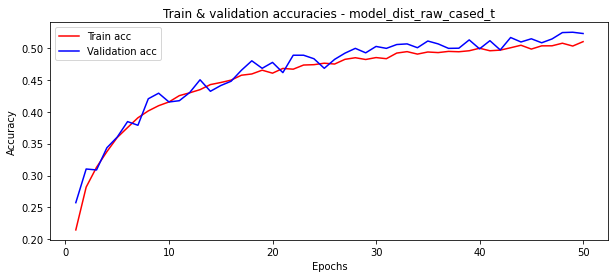

In [ ]:
modelize(model_dist_raw_cased, 50, data, "model_dist_raw_cased_t")

Les modélisations donnent lieu à de nombreux messages. Nous reproduirons des captures de leurs résultats.<br><br><img src="images/distilbert_cased_raw.png" width = "600" heights = "336">

**Fine-tuning**

In [ ]:
# Toutes les couches du modèle sont désormais entraînables...
for layer in model_dist_raw_cased.layers :
    layer.trainable = True
    
# ...sauf la dernière
model_dist_raw_cased.layers[-1].trainable = False

# recompilation du modèle avec assignation d'un LR plus petit...
model_dist_raw_cased.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                             loss = 'binary_crossentropy',
                             metrics='accuracy')

Epoch 1/20


500/500 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.6416WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 72s 67ms/step - loss: 0.0876 - accuracy: 0.6416 - val_loss: 0.0769 - val_accuracy: 0.6743
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0683 - accuracy: 0.6992 - val_loss: 0.0688 - val_accuracy: 0.6913
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0578 - accuracy: 0.7276 - val_loss: 0.0695 - val_accuracy: 0.6985
Epoch 4/20
500/500 [==============================] - 29s 57ms/step - loss: 0.0501 - accuracy: 0.7491 - val_loss: 0.0686 - val_accuracy: 0.7103
Epoch 5/20
500/500 [==============================] - 29s 57ms/step - loss: 0.0432 - accuracy: 0.7687 - val_loss: 0.0681 - val_accuracy: 0.7113
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0357 - accuracy: 0.7915 - val_loss: 0.0751 - val_accuracy: 0.7045
Epoch 7/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0298 - accuracy: 0.8074 - val_loss: 0.0776 - val_accuracy: 0.7053
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 210) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 210) dtype=int32>]



Temps d'entrainements pour 20 epochs : 626 secondes.
Meilleure train_acc = 0.864, meilleure val_acc = 0.716

F1_score obtenu : 0.76


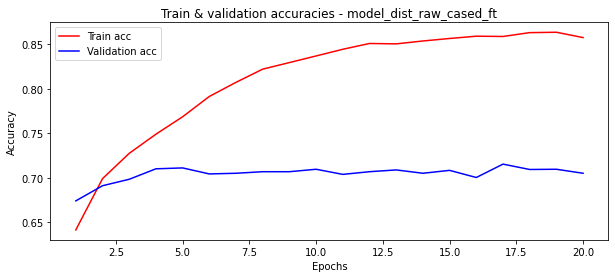

In [ ]:
modelize(model_dist_raw_cased, 20, data, "model_dist_raw_cased_ft")

<br><img src="images/distilbert_cased_raw_ft.png" width = "600" heights = "336">

Nous y reviendrons, mais on peut noter que ce premier résultat est intéressant puisqu'il améliore sensiblement ce que nous avions obtenu lors du **projet 5**, à savoir un **f1_score_weighted** de **0,69**.<br><br>**Remarque :**<br>Toutes les modélisations que nous avons effectuées ont suivi  le cheminement que nous venons de décrire.

## **2-b) DistilBERT uncased données brutes**

**Chargement du modèle**

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

**Encodage**

In [ ]:
start = time()
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)
print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 21 secondes.


**Création du modèle**

In [ ]:
def build_distil_model(max_length = MAX_LENGTH):

    distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    for layer in distilBERT.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    last_hidden_state = distilBERT([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]
    
    output = tf.keras.layers.Dense(25, 
                                   activation='sigmoid'
                                   )(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')
    
    return model

In [ ]:
with strategy.scope():
    model_dist_raw = build_distil_model()
    model_dist_raw.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

**Représentation du modèle**

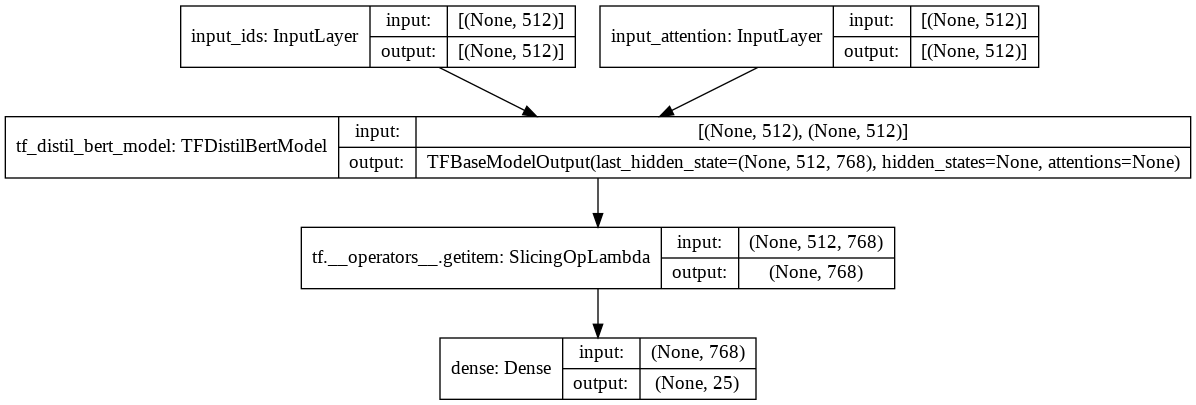

In [ ]:
tf.keras.utils.plot_model(model_dist_raw, "model_dist_raw.png", show_shapes=True)

Epoch 1/50


500/500 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.2551WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 28s 38ms/step - loss: 0.1862 - accuracy: 0.2551 - val_loss: 0.1672 - val_accuracy: 0.3105
Epoch 2/50
500/500 [==============================] - 16s 31ms/step - loss: 0.1610 - accuracy: 0.3434 - val_loss: 0.1543 - val_accuracy: 0.3683
Epoch 3/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1508 - accuracy: 0.3915 - val_loss: 0.1459 - val_accuracy: 0.4373
Epoch 4/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1442 - accuracy: 0.4255 - val_loss: 0.1399 - val_accuracy: 0.4525
Epoch 5/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1393 - accuracy: 0.4478 - val_loss: 0.1352 - val_accuracy: 0.4643
Epoch 6/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1353 - accuracy: 0.4603 - val_loss: 0.1317 - val_accuracy: 0.4773
Epoch 7/50
500/500 [==============================] - 16s 31ms/step - loss: 0.1323 - accuracy: 0.4770 - val_loss: 0.1295 - val_accuracy: 0.4993
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 830 secondes.
Meilleure train_acc = 0.561, meilleure val_acc = 0.573

F1_score obtenu : 0.50


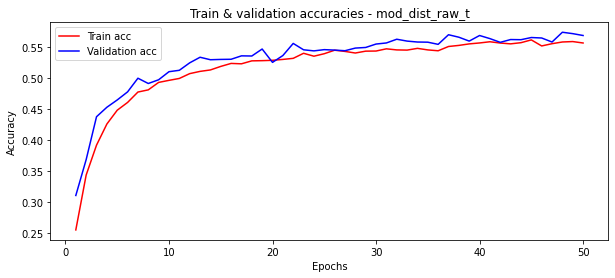

In [ ]:
modelize(model_dist_raw, 50, data, "mod_dist_raw_t")

<br><img src="images/distilbert_uncased_raw_t.png" width = "600" heights = "336">

**Fine-tuning**

In [ ]:
for layer in model_dist_raw.layers :
    layer.trainable = True
    
model_dist_raw.layers[-1].trainable = False

**Recompilation**

In [ ]:
model_dist_raw.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

model_dist_raw.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

Epoch 1/20


500/500 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.6553WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 82s 88ms/step - loss: 0.0802 - accuracy: 0.6553 - val_loss: 0.0720 - val_accuracy: 0.6858
Epoch 2/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0633 - accuracy: 0.7086 - val_loss: 0.0670 - val_accuracy: 0.6973
Epoch 3/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0548 - accuracy: 0.7327 - val_loss: 0.0659 - val_accuracy: 0.6930
Epoch 4/20
500/500 [==============================] - 40s 79ms/step - loss: 0.0471 - accuracy: 0.7525 - val_loss: 0.0650 - val_accuracy: 0.7068
Epoch 5/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0406 - accuracy: 0.7741 - val_loss: 0.0696 - val_accuracy: 0.7060
Epoch 6/20
500/500 [==============================] - 39s 78ms/step - loss: 0.0337 - accuracy: 0.7939 - val_loss: 0.0779 - val_accuracy: 0.6928
Epoch 7/20
500/500 [==============================] - 40s 79ms/step - loss: 0.0276 - accuracy: 0.8092 - val_loss: 0.0782 - val_accuracy: 0.7053
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 857 secondes.
Meilleure train_acc = 0.864, meilleure val_acc = 0.717

F1_score obtenu : 0.78


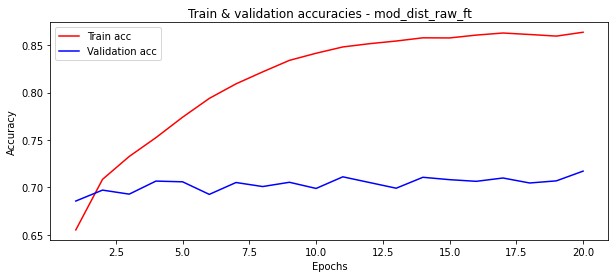

In [ ]:
modelize(model_dist_raw, 20, data, "mod_dist_raw_ft")

<br><img src="images/distilbert_uncased_raw_ft.png" width = "600" heights = "336">

Les résultats sont meilleurs (F1score_weighted : **0.78**) avec la version **uncased** de DistilBERT. Nous utiliserons désormais ce type de version des modèles.

## **2-c) DistilBERT données "cleanées"**

In [ ]:
# encodage données nettoyées
start = time()
X_train_cl_ids, X_train_cl_attention = batch_encode(tokenizer, X_clean_train)
X_test_cl_ids, X_test_cl_attention = batch_encode(tokenizer, X_clean_test)
print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 21 secondes.


In [ ]:
# encodage données nettoyées et sans stopwords ni ponctuation
start = time()
X_train_sw_ids, X_train_sw_attention = batch_encode(tokenizer, X_sw_train, max_length=MAX_LENGTH_SW)
X_test_sw_ids, X_test_sw_attention = batch_encode(tokenizer, X_sw_test, max_length=MAX_LENGTH_SW)
print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 19 secondes.


In [ ]:
data_cl = [[X_train_cl_ids, X_train_cl_attention], y_train, [X_test_cl_ids, X_test_cl_attention], y_test]
data_sw = [[X_train_sw_ids, X_train_sw_attention], y_train, [X_test_sw_ids, X_test_sw_attention], y_test]

**Création du modèle**

In [ ]:
with strategy.scope():
    model_dist_cl = build_distil_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**Entrainement DistilBERT avec données nettoyées**

Epoch 1/50


499/500 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.2583WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 29s 39ms/step - loss: 0.1864 - accuracy: 0.2586 - val_loss: 0.1688 - val_accuracy: 0.3085
Epoch 2/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1632 - accuracy: 0.3315 - val_loss: 0.1568 - val_accuracy: 0.3640
Epoch 3/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1534 - accuracy: 0.3769 - val_loss: 0.1487 - val_accuracy: 0.3863
Epoch 4/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1471 - accuracy: 0.4023 - val_loss: 0.1427 - val_accuracy: 0.4453
Epoch 5/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1421 - accuracy: 0.4232 - val_loss: 0.1405 - val_accuracy: 0.4223
Epoch 6/50
500/500 [==============================] - 15s 30ms/step - loss: 0.1387 - accuracy: 0.4400 - val_loss: 0.1351 - val_accuracy: 0.4668
Epoch 7/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1357 - accuracy: 0.4532 - val_loss: 0.1333 - val_accuracy: 0.4753
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 860 secondes.
Meilleure train_acc = 0.548, meilleure val_acc = 0.558

F1_score obtenu : 0.46


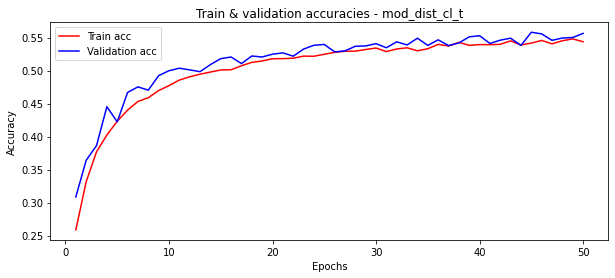

In [ ]:
modelize(model_dist_cl, 50, data_cl, "mod_dist_cl_t")

<br><img src="images/distilbert_uncased_cl_t.png" width = "600" heights = "336">

**Fine_tuning**

In [ ]:
# Toutes les couches du modèle sont désormais entraînables...
for layer in model_dist_cl.layers :
    layer.trainable = True
    
# ...sauf la dernière
model_dist_cl.layers[-1].trainable = False

# recompilation du modèle avec assignation d'un LR plus petit...
model_dist_cl.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


500/500 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.6512WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 84s 89ms/step - loss: 0.0819 - accuracy: 0.6512 - val_loss: 0.0715 - val_accuracy: 0.6818
Epoch 2/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0649 - accuracy: 0.7035 - val_loss: 0.0671 - val_accuracy: 0.6908
Epoch 3/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0560 - accuracy: 0.7294 - val_loss: 0.0667 - val_accuracy: 0.6945
Epoch 4/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0485 - accuracy: 0.7516 - val_loss: 0.0685 - val_accuracy: 0.6940
Epoch 5/20
500/500 [==============================] - 40s 79ms/step - loss: 0.0423 - accuracy: 0.7699 - val_loss: 0.0707 - val_accuracy: 0.6998
Epoch 6/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0349 - accuracy: 0.7916 - val_loss: 0.0722 - val_accuracy: 0.7085
Epoch 7/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0288 - accuracy: 0.8096 - val_loss: 0.0822 - val_accuracy: 0.6960
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 863 secondes.
Meilleure train_acc = 0.864, meilleure val_acc = 0.710

F1_score obtenu : 0.77


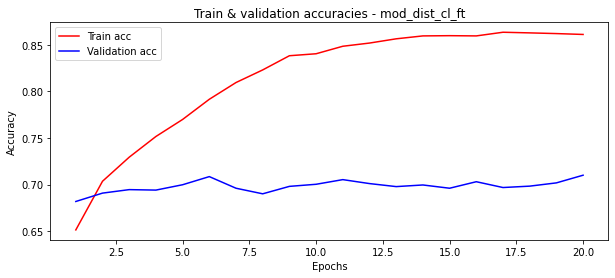

In [ ]:
modelize(model_dist_cl, 20, data_cl, "mod_dist_cl_ft") # fine-tuning

<br><img src="images/distilbert_uncased_cl_ft.png" width = "600" heights = "336">

**Création du modèle**

In [ ]:
with strategy.scope():
    model_dist_sw = build_distil_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**Entrainement DistilBERT avec données nettoyées y compris stopwords et ponctuation**

Epoch 1/50


500/500 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.2534WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 29s 39ms/step - loss: 0.1890 - accuracy: 0.2534 - val_loss: 0.1685 - val_accuracy: 0.3175
Epoch 2/50
500/500 [==============================] - 16s 31ms/step - loss: 0.1617 - accuracy: 0.3367 - val_loss: 0.1555 - val_accuracy: 0.3450
Epoch 3/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1514 - accuracy: 0.3820 - val_loss: 0.1479 - val_accuracy: 0.3975
Epoch 4/50
500/500 [==============================] - 16s 31ms/step - loss: 0.1448 - accuracy: 0.4136 - val_loss: 0.1426 - val_accuracy: 0.4520
Epoch 5/50
500/500 [==============================] - 16s 31ms/step - loss: 0.1402 - accuracy: 0.4309 - val_loss: 0.1384 - val_accuracy: 0.4350
Epoch 6/50
500/500 [==============================] - 15s 30ms/step - loss: 0.1362 - accuracy: 0.4501 - val_loss: 0.1347 - val_accuracy: 0.4710
Epoch 7/50
500/500 [==============================] - 16s 32ms/step - loss: 0.1333 - accuracy: 0.4594 - val_loss: 0.1327 - val_accuracy: 0.4865
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 838 secondes.
Meilleure train_acc = 0.545, meilleure val_acc = 0.560

F1_score obtenu : 0.47


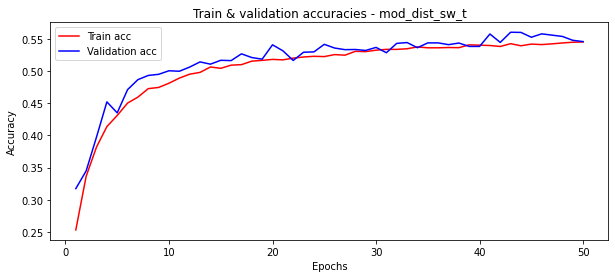

In [ ]:
modelize(model_dist_sw, 50, data_sw, "mod_dist_sw_t")

<br><img src="images/distilbert_uncased_sw_t.png" width = "600" heights = "336">

**Fine-tuning**

In [ ]:
for layer in model_dist_sw.layers :
    layer.trainable = True
    
model_dist_sw.layers[-1].trainable = False

model_dist_sw.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


500/500 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.6457WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 84s 88ms/step - loss: 0.0839 - accuracy: 0.6457 - val_loss: 0.0746 - val_accuracy: 0.6713
Epoch 2/20
500/500 [==============================] - 41s 82ms/step - loss: 0.0667 - accuracy: 0.6961 - val_loss: 0.0690 - val_accuracy: 0.6860
Epoch 3/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0582 - accuracy: 0.7204 - val_loss: 0.0686 - val_accuracy: 0.6913
Epoch 4/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0507 - accuracy: 0.7413 - val_loss: 0.0672 - val_accuracy: 0.6973
Epoch 5/20
500/500 [==============================] - 40s 80ms/step - loss: 0.0439 - accuracy: 0.7637 - val_loss: 0.0704 - val_accuracy: 0.6970
Epoch 6/20
500/500 [==============================] - 39s 79ms/step - loss: 0.0376 - accuracy: 0.7827 - val_loss: 0.0751 - val_accuracy: 0.6905
Epoch 7/20
500/500 [==============================] - 39s 79ms/step - loss: 0.0313 - accuracy: 0.8029 - val_loss: 0.0830 - val_accuracy: 0.6963
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 876 secondes.
Meilleure train_acc = 0.863, meilleure val_acc = 0.705

F1_score obtenu : 0.77


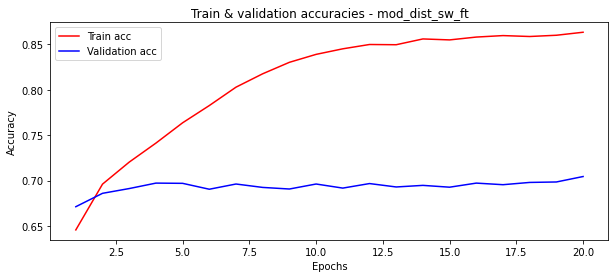

In [ ]:
modelize(model_dist_sw, 20, data_sw, "mod_dist_sw_ft") # fine-tuning

<br><img src="images/distilbert_uncased_sw_ft.png" width = "600" heights = "336">

On tire deux enseignements de ces résultats :<br><br>D'abord, si les résultats des trois jeux de données sont dans un mouchoir de poche, ceux obtenus à partir des données brutes sont au moins équivalents sinon meilleurs que les autres. Cela confirme que les modèles de type **Bert** sont en effet conçus pour fonctionner à partir de données non-traitées. Ce sont elles que nous utiliserons désormais pour tester d'autres modèles.<br><br>Ensuite, pour revenir à notre projet, on voit que l'utilisation du modèle **DistilBert uncased** nous a fait gagner **8 points** par rapport au meilleur résultat obtenu en fin de **projet 5**.<br><br>Essayons maintenant d'autres modèles. 

# **3-) Modèle BERT**

Implémentation du modèle **BERT** original mis au point par Google dans sa version **medium**.

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

**Encodage des données**

In [ ]:
start = time()

X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

data_bert = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 77 secondes.


**Création du modèle**

In [ ]:
def build_bert_model(max_length = MAX_LENGTH):
                    

    bert = TFBertModel.from_pretrained('bert-base-uncased')
    
    for layer in bert.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')

    last_hidden_state = bert([input_ids_layer, input_attention_layer])[0]
    
    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')
    
    return model

In [ ]:
with strategy.scope():
    model_bert = build_bert_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**Entrainement**

Epoch 1/50


499/500 [============================>.] - ETA: 0s - loss: 0.1874 - accuracy: 0.2587WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 48s 63ms/step - loss: 0.1874 - accuracy: 0.2587 - val_loss: 0.1654 - val_accuracy: 0.3195
Epoch 2/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1605 - accuracy: 0.3474 - val_loss: 0.1519 - val_accuracy: 0.3715
Epoch 3/50
500/500 [==============================] - 26s 53ms/step - loss: 0.1509 - accuracy: 0.3888 - val_loss: 0.1437 - val_accuracy: 0.4115
Epoch 4/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1444 - accuracy: 0.4168 - val_loss: 0.1398 - val_accuracy: 0.4190
Epoch 5/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1403 - accuracy: 0.4316 - val_loss: 0.1341 - val_accuracy: 0.4783
Epoch 6/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1371 - accuracy: 0.4452 - val_loss: 0.1313 - val_accuracy: 0.4885
Epoch 7/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1348 - accuracy: 0.4542 - val_loss: 0.1300 - val_accuracy: 0.4775
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 1412 secondes.
Meilleure train_acc = 0.509, meilleure val_acc = 0.550

F1_score obtenu : 0.43


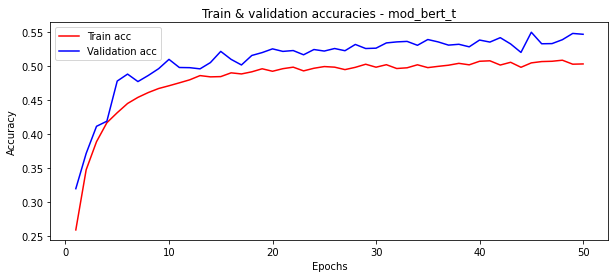

In [ ]:
modelize(model_bert, 50, data_bert, "mod_bert_t")

<br><img src="images/bert_t.png" width = "600" heights = "336">

**Fine-tuning**

In [ ]:
for layer in model_bert.layers :
    layer.trainable = True
    
model_bert.layers[-1].trainable = False

model_bert.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


500/500 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.6583WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 113s 104ms/step - loss: 0.0801 - accuracy: 0.6583 - val_loss: 0.0718 - val_accuracy: 0.6865
Epoch 2/20
500/500 [==============================] - 46s 92ms/step - loss: 0.0622 - accuracy: 0.7132 - val_loss: 0.0658 - val_accuracy: 0.6998
Epoch 3/20
500/500 [==============================] - 46s 92ms/step - loss: 0.0528 - accuracy: 0.7421 - val_loss: 0.0649 - val_accuracy: 0.7058
Epoch 4/20
500/500 [==============================] - 46s 92ms/step - loss: 0.0448 - accuracy: 0.7628 - val_loss: 0.0674 - val_accuracy: 0.7068
Epoch 5/20
500/500 [==============================] - 47s 93ms/step - loss: 0.0375 - accuracy: 0.7864 - val_loss: 0.0710 - val_accuracy: 0.7065
Epoch 6/20
500/500 [==============================] - 46s 92ms/step - loss: 0.0311 - accuracy: 0.8062 - val_loss: 0.0763 - val_accuracy: 0.7070
Epoch 7/20
500/500 [==============================] - 47s 95ms/step - loss: 0.0248 - accuracy: 0.8200 - val_loss: 0.0849 - val_accuracy: 0.7083
E

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 210) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 210) dtype=int32>]



Temps d'entrainements pour 20 epochs : 1044 secondes.
Meilleure train_acc = 0.861, meilleure val_acc = 0.716

F1_score obtenu : 0.78


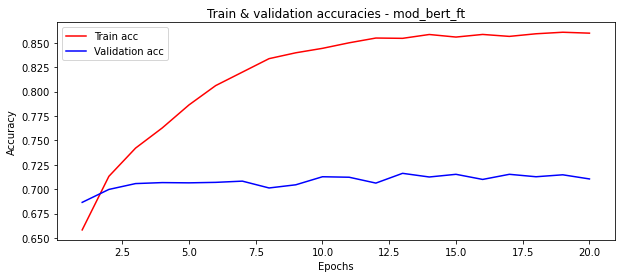

In [ ]:
modelize(model_bert, 20, data_bert, "mod_bert_ft")

<br><img src="images/bert_ft.png" width = "600" heights = "336">

In [ ]:
results_small["Bert"] = {"Training" : (0.550, 0.43), "Fine-Tuning": (0.716, 0.78)}

pickle_out = open(path_data + "results_small.pickle", "wb")
pickle.dump(results_small, pickle_out)
pickle_out.close()

## **4-) Modèle SciBERT**

In [ ]:
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
start = time()

X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

data_sci = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 21 secondes.


In [ ]:
def build_sci_model(max_length = MAX_LENGTH):
                    
    sci_mod = TFAutoModel.from_pretrained('allenai/scibert_scivocab_uncased', from_pt=True)

    for layer in sci_mod.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')

    last_hidden_state = sci_mod([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')
    
    return model

In [ ]:
with strategy.scope():
    model_sci = build_sci_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/50


499/500 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.2532WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 46s 61ms/step - loss: 0.1882 - accuracy: 0.2533 - val_loss: 0.1669 - val_accuracy: 0.3415
Epoch 2/50
500/500 [==============================] - 26s 51ms/step - loss: 0.1622 - accuracy: 0.3418 - val_loss: 0.1571 - val_accuracy: 0.3588
Epoch 3/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1544 - accuracy: 0.3713 - val_loss: 0.1519 - val_accuracy: 0.3688
Epoch 4/50
500/500 [==============================] - 26s 51ms/step - loss: 0.1491 - accuracy: 0.3968 - val_loss: 0.1469 - val_accuracy: 0.4065
Epoch 5/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1464 - accuracy: 0.3982 - val_loss: 0.1437 - val_accuracy: 0.4033
Epoch 6/50
500/500 [==============================] - 25s 49ms/step - loss: 0.1438 - accuracy: 0.4131 - val_loss: 0.1424 - val_accuracy: 0.4120
Epoch 7/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1421 - accuracy: 0.4193 - val_loss: 0.1418 - val_accuracy: 0.4105
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 1419 secondes.
Meilleure train_acc = 0.458, meilleure val_acc = 0.479

F1_score obtenu : 0.34


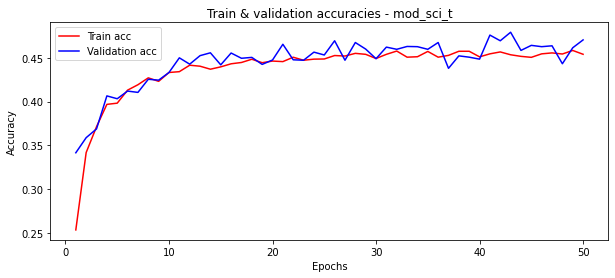

In [ ]:
modelize(model_sci, 50, data_sci, "mod_sci_t")

<br><img src="images/scibert_t.png" width = "600" heights = "336">

**Fine-tuning SciBERT**

In [ ]:
for layer in model_sci.layers :
    layer.trainable = True
    
model_sci.layers[-1].trainable = False

model_sci.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


500/500 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.6564WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 138s 154ms/step - loss: 0.0804 - accuracy: 0.6564 - val_loss: 0.0679 - val_accuracy: 0.6923
Epoch 2/20
500/500 [==============================] - 71s 142ms/step - loss: 0.0606 - accuracy: 0.7086 - val_loss: 0.0652 - val_accuracy: 0.6990
Epoch 3/20
500/500 [==============================] - 71s 143ms/step - loss: 0.0503 - accuracy: 0.7442 - val_loss: 0.0637 - val_accuracy: 0.7063
Epoch 4/20
500/500 [==============================] - 71s 142ms/step - loss: 0.0419 - accuracy: 0.7674 - val_loss: 0.0659 - val_accuracy: 0.7100
Epoch 5/20
500/500 [==============================] - 71s 142ms/step - loss: 0.0341 - accuracy: 0.7871 - val_loss: 0.0701 - val_accuracy: 0.7143
Epoch 6/20
500/500 [==============================] - 71s 143ms/step - loss: 0.0267 - accuracy: 0.8080 - val_loss: 0.0772 - val_accuracy: 0.7013
Epoch 7/20
500/500 [==============================] - 71s 141ms/step - loss: 0.0211 - accuracy: 0.8262 - val_loss: 0.0791 - val_accuracy: 0.

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 1541 secondes.
Meilleure train_acc = 0.855, meilleure val_acc = 0.719

F1_score obtenu : 0.78


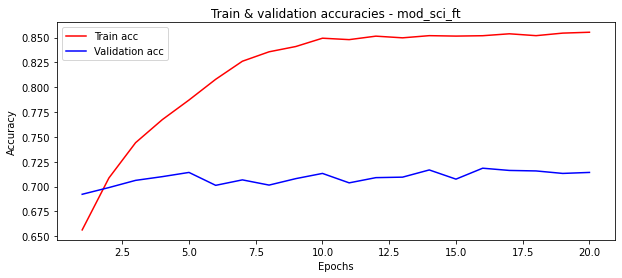

In [ ]:
modelize(model_sci, 20, data_sci, "mod_sci_ft")

<br><img src="images/scibert_ft.png" width = "600" heights = "336">

In [ ]:
results_small["SciBert"] = {"Training" : (0.479, 0.34), "Fine-Tuning": (0.719, 0.78)}

pickle_out = open(path_data + "results_small.pickle", "wb")
pickle.dump(results_small, pickle_out)
pickle_out.close()

## **5-) Modèle RoBERTa**

In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
start = time()

X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

data_berta = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 27 secondes.


In [ ]:
def build_berta_model(max_length = MAX_LENGTH):
                    
    roberta = TFRobertaModel.from_pretrained("roberta-base")

    for layer in roberta.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')

    last_hidden_state = roberta([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')
    
    return model

In [ ]:
with strategy.scope():
    model_berta = build_berta_model()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


499/500 [============================>.] - ETA: 0s - loss: 0.2335 - accuracy: 0.1804WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 46s 62ms/step - loss: 0.2335 - accuracy: 0.1803 - val_loss: 0.1888 - val_accuracy: 0.1930
Epoch 2/50
500/500 [==============================] - 27s 53ms/step - loss: 0.1925 - accuracy: 0.2219 - val_loss: 0.1828 - val_accuracy: 0.2270
Epoch 3/50
500/500 [==============================] - 27s 54ms/step - loss: 0.1842 - accuracy: 0.2594 - val_loss: 0.1774 - val_accuracy: 0.2808
Epoch 4/50
500/500 [==============================] - 26s 52ms/step - loss: 0.1782 - accuracy: 0.2889 - val_loss: 0.1726 - val_accuracy: 0.3188
Epoch 5/50
500/500 [==============================] - 27s 53ms/step - loss: 0.1727 - accuracy: 0.3181 - val_loss: 0.1685 - val_accuracy: 0.3355
Epoch 6/50
500/500 [==============================] - 27s 54ms/step - loss: 0.1685 - accuracy: 0.3339 - val_loss: 0.1650 - val_accuracy: 0.3435
Epoch 7/50
500/500 [==============================] - 27s 53ms/step - loss: 0.1651 - accuracy: 0.3510 - val_loss: 0.1615 - val_accuracy: 0.3658
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 1472 secondes.
Meilleure train_acc = 0.486, meilleure val_acc = 0.521

F1_score obtenu : 0.25


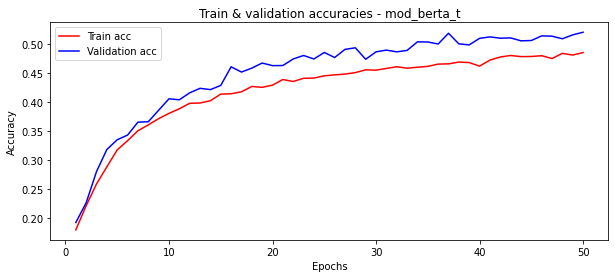

In [ ]:
modelize(model_berta, 50, data_berta, "mod_berta_t")

<br><img src="images/berta_t.png" width = "600" heights = "336">

**Fine-tuning**

In [ ]:
for layer in model_berta.layers :
    layer.trainable = True
    
model_berta.layers[-1].trainable = False

model_berta.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


500/500 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.6454WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 145s 157ms/step - loss: 0.0870 - accuracy: 0.6454 - val_loss: 0.0685 - val_accuracy: 0.6775
Epoch 2/20
500/500 [==============================] - 73s 147ms/step - loss: 0.0706 - accuracy: 0.6936 - val_loss: 0.0674 - val_accuracy: 0.6870
Epoch 3/20
500/500 [==============================] - 74s 147ms/step - loss: 0.0635 - accuracy: 0.7139 - val_loss: 0.0641 - val_accuracy: 0.6908
Epoch 4/20
500/500 [==============================] - 74s 147ms/step - loss: 0.0582 - accuracy: 0.7271 - val_loss: 0.0631 - val_accuracy: 0.6995
Epoch 5/20
500/500 [==============================] - 74s 148ms/step - loss: 0.0525 - accuracy: 0.7439 - val_loss: 0.0642 - val_accuracy: 0.7020
Epoch 6/20
500/500 [==============================] - 74s 148ms/step - loss: 0.0469 - accuracy: 0.7598 - val_loss: 0.0632 - val_accuracy: 0.7105
Epoch 7/20
500/500 [==============================] - 74s 148ms/step - loss: 0.0426 - accuracy: 0.7733 - val_loss: 0.0669 - val_accuracy: 0.

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 1612 secondes.
Meilleure train_acc = 0.855, meilleure val_acc = 0.724

F1_score obtenu : 0.78


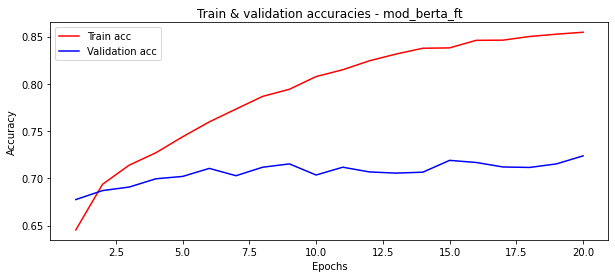

In [ ]:
modelize(model_berta, 20, data_berta, "mod_berta_ft")

<br><img src="images/berta_ft.png" width = "600" heights = "336">

In [ ]:
results_small["Roberta"] = {"Training" : (0.521, 0.25), "Fine-Tuning": (0.724, 0.78)}

pickle_out = open(path_data + "results_small.pickle", "wb")
pickle.dump(results_small, pickle_out)
pickle_out.close()

## **Résultats**

Après cette série de modélisation, les résultats sont les suivants (val_accuracy, f1_score_weighted).

In [ ]:
res = pd.DataFrame.from_dict(results_small, orient='index')
res

,Training,Fine-Tuning
DistilBert,"(0.573, 0.5)","(0.717, 0.78)"
Bert,"(0.55, 0.43)","(0.716, 0.78)"
SciBert,"(0.479, 0.34)","(0.719, 0.78)"
Roberta,"(0.521, 0.25)","(0.724, 0.78)"


Les quatre modèles donnent des résultats se trouvant dans un mouchoir de poche.<br><br>Second point, on a pu observer à chaque fois des profils de modélisation similaires qui, malgré de meilleurs scores que ceux du projet 5, montre un fort déficit de généralisation. Pour remédier en partie à cela, nous pensons qu'il serait pertinent de travailler sur plus de données.<br><br>Le notebook suivant relate la constrution d'un nouveau dataset. Celui d'après les modélisations à partir de celui-ci.

**Fin de la première partie.**